## EAEEE4000_001_Final Project_First Model Code --- Using XGBoost
#### Name: Jiuhe(Rebecca) Shi (UNI: js6112)
#### Project Title: Prediction of Ocen Partial Pressure of CO2 (pCO2)  by Using XGBoost, Random Forest and LSTM
#### Date: December, 2022

### Decision Tree Background

Two models used in this project are widely decision trees, but the ensemble are different. Decision trees are supervised machine learning, classified or predicted according to the way the previous set of questions were answered. It is mainly divided into two categories: classification and continuous. In this project, whether it is a XGBoost or a random forest, because the purpose of this project is to predict the value of the partial pressure of carbon dioxide at sea level, it belongs to the scope of the continuous variable decision tree, also known as the regression tree. Multiple variables are used to predict the results, and the prediction process can be used either linearly or nonlinearly. 

Reference - [`Decision-Tree` ](https://www.mastersindatascience.org/learning/machine-learning-algorithms/decision-tree).

### XGBoost Introduction

XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. The principle of the XGBoost algorithm is to supervise machine learning to use algorithms to train models, so as to find a pattern with significant features in the data, so as to use the trained model to predict whether there are relevant features or labels in the data set afterward.

Reference - [`XGBoost` ](https://www.nvidia.com/en-us/glossary/data-science/xgboost/).

![RF](images/XGB.jpg)


## Own Project Model Building Figure

In this project, the purpose of this machine learning approach is to utilize more available predictors to find the relationship more accurately and analytically between ocean pCO2 and fCO2, compared with the numerical relationship mentioned above. In addition, it provides a basic basis for evaluating the flow direction and absorption value of CO2 absorbed by the ocean.

In order to facilitate the observation of the whole model and model parameters I used, the following figure is my  data flow images of three models. It also included the parameters I use in models.

![RF](images/3_models_Procedures.jpg)

### CODING PART

### Load all packages used in this project

In [3]:
# packages used in this tutorial 
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import pandas as pd
import joblib
# Extreme Gradient Boosting 
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import train_test_split
# evaluation metrics
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_regression
from utils import * 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Open & Clean the Merged Dataset  

In [4]:
data = xr.open_dataset('MERGED-DATA_1x1_mon_198201-202112.nc')
data = data.sel(time=slice('1982', '2021')).load()
data_pd = data.to_dataframe()

In [12]:
data_clean = data_pd[data_pd['fco2_ave_unwtd'].notnull() & data_pd['mld'].notnull() & data_pd['chl'].notnull()
                    & data_pd['mask'].notnull() & data_pd['sss'].notnull() & data_pd['sst'].notnull() 
                     & data_pd['atm_pco2_uatm'].notnull()]
data_clean

fco2_ave_unwtd         mld       chl  mask        sss  \
time       lat   lon                                                            
1982-01-15 -0.5  137.5      320.476288   34.367130  0.213072   1.0  34.227975   
            0.5  137.5      336.389130   33.478939  0.130572   1.0  34.261681   
            1.5  137.5      342.459686   39.543957  0.126997   1.0  34.302076   
            2.5  136.5      343.751190   23.772850  0.133725   1.0  34.300365   
                 137.5      344.493958   45.244648  0.128011   1.0  34.309180   
...                                ...         ...       ...   ...        ...   
2021-12-15  44.5 334.5      377.762512  129.950058  0.180022   1.0  35.823172   
                 341.5      382.966675  109.925339  0.469160   1.0  35.762420   
                 342.5      386.497375   84.819145  0.402202   1.0  35.757088   
            45.5 348.5      395.024994  102.078323  0.617956   1.0  35.662514   
            46.5 350.5      396.402771  100.040131  0.241002   1.0  35.623573   

                              sst  atm_pco2_uatm  
time       lat   lon                              
1982-01-15 -0.5  137.5  29.022418     331.245001  
            0.5  137.5  29.269918     331.245001  
            1.5  137.5  29.666697     331.245001  
            2.5  136.5  29.420000     331.245001  
                 137.5  29.702498     331.245001  
...                           ...            ...  
2021-12-15  44.5 334.5  16.412507     404.900235  
                 341.5  15.100598     404.900235  
                 342.5  15.084283     404.900235  
            45.5 348.5  14.092825     404.900235  
            46.5 350.5  13.716935     404.900235  

[252850 rows x 7 columns]

### Slicing Data & Building XGBoost Training Model

In [13]:
# Slicing the data 
X, Y = data_clean.iloc[:,:-1],data_clean.iloc[:,-1]

# Split the Data for training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [14]:
%%time
# XGBoost parameters
param_best = {'objective': 'reg:squarederror', 
              #'reg:squarederror', For Bias prediction 
              'n_estimators': 40, 
              # number of runs XGBoost will try to learn
              'max_depth': 13, 
              # Maximum depth of a tree, how many levels are in each tree
              'num_parallel_tree':15,
              # Number of parallel trees constructed during each iteration
              'gamma': 0,
              # Minimum loss reduction required to make a further partition on a leaf node of the tree
              'colsample_bytree': 0.95,
              # Subsample ratio of columns when constructing each tree
              
              # PREVENT OVERFITTING:
              'learning_rate': 0.38,
              # Step size shrinkage used in update to prevents overfitting
              #'min_child_weight': 1, 
              # Minimum sum of instance weight (hessian) needed in a child
              'subsample': 0.85,
              # Subsample ratio of the training instances
              
              # REGULARIZATION:
              #'alpha': 0.09,
              # L1 regularization term on weights
              #'labmda': 1,
              # L2 regularization term on weights
            }
# XGBoost Regressor
model = xgb.XGBRegressor(**param_best)
# XGBoost training model
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
Y_pred_train = model.predict(X_train)

/Users/rebecca/opt/anaconda3/envs/keras/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


CPU times: user 8min 42s, sys: 1min 21s, total: 10min 3s
Wall time: 1min 26s


### Save & Load Model

In [15]:
now = datetime.now()
timestamp = now.strftime("%m-%d-%Y-%H:%M:%S")
joblib.dump(model, "best_model/XGBmodel-{}.joblib".format(timestamp))

# load model
# loaded_model = joblib.load("./random_forest.joblib")

['best_model/XGBmodel-12-23-2022-16:03:05.joblib']

### Model Training Result : Evaluation Matrix Data

In [16]:
# Mean Absolute Error, Mean Square Error, Root Mean Square Error
MAE = mean_absolute_error(Y_test,Y_pred)
print('MAE:',metrics.mean_absolute_error(Y_test,Y_pred))

MSE = mean_squared_error(Y_test, Y_pred)
print(f'MSE: {MSE}')

RMSE = np.sqrt(mean_squared_error(Y_test, Y_pred))
print("RMSE: %f" % (RMSE))

MAE: 8.371673360791291
MSE: 118.3985546503586
RMSE: 10.881110


### Relationship Between Predicted Values & True Values 

### Y_train vs. Y_pred_train

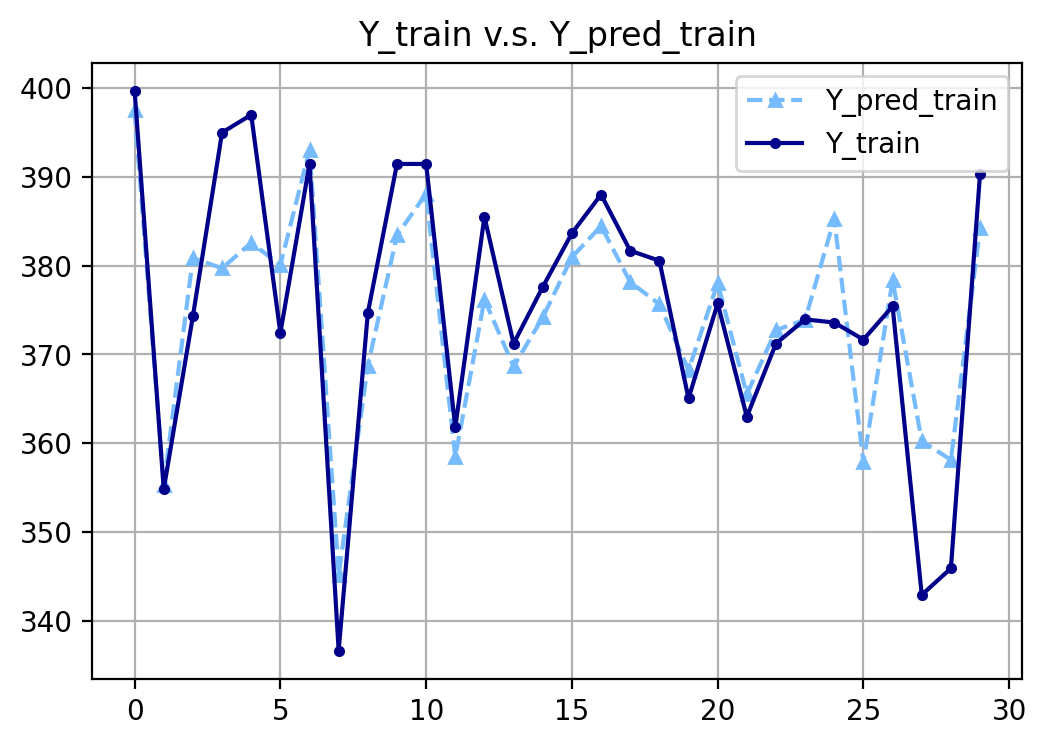

In [17]:
Y_pred_train = model.predict(X_train)
plt.figure(figsize=(6, 4))
plt.plot(Y_pred_train[:30,], label='Y_pred_train', marker= '^', 
         markersize=4, color= 'xkcd:sky blue', 
         linestyle='--')
plt.plot(Y_train.values[:30,], label='Y_train', marker= '.', color= 'darkblue')
plt.title("Y_train v.s. Y_pred_train")
plt.grid()
plt.legend()
plt.show()

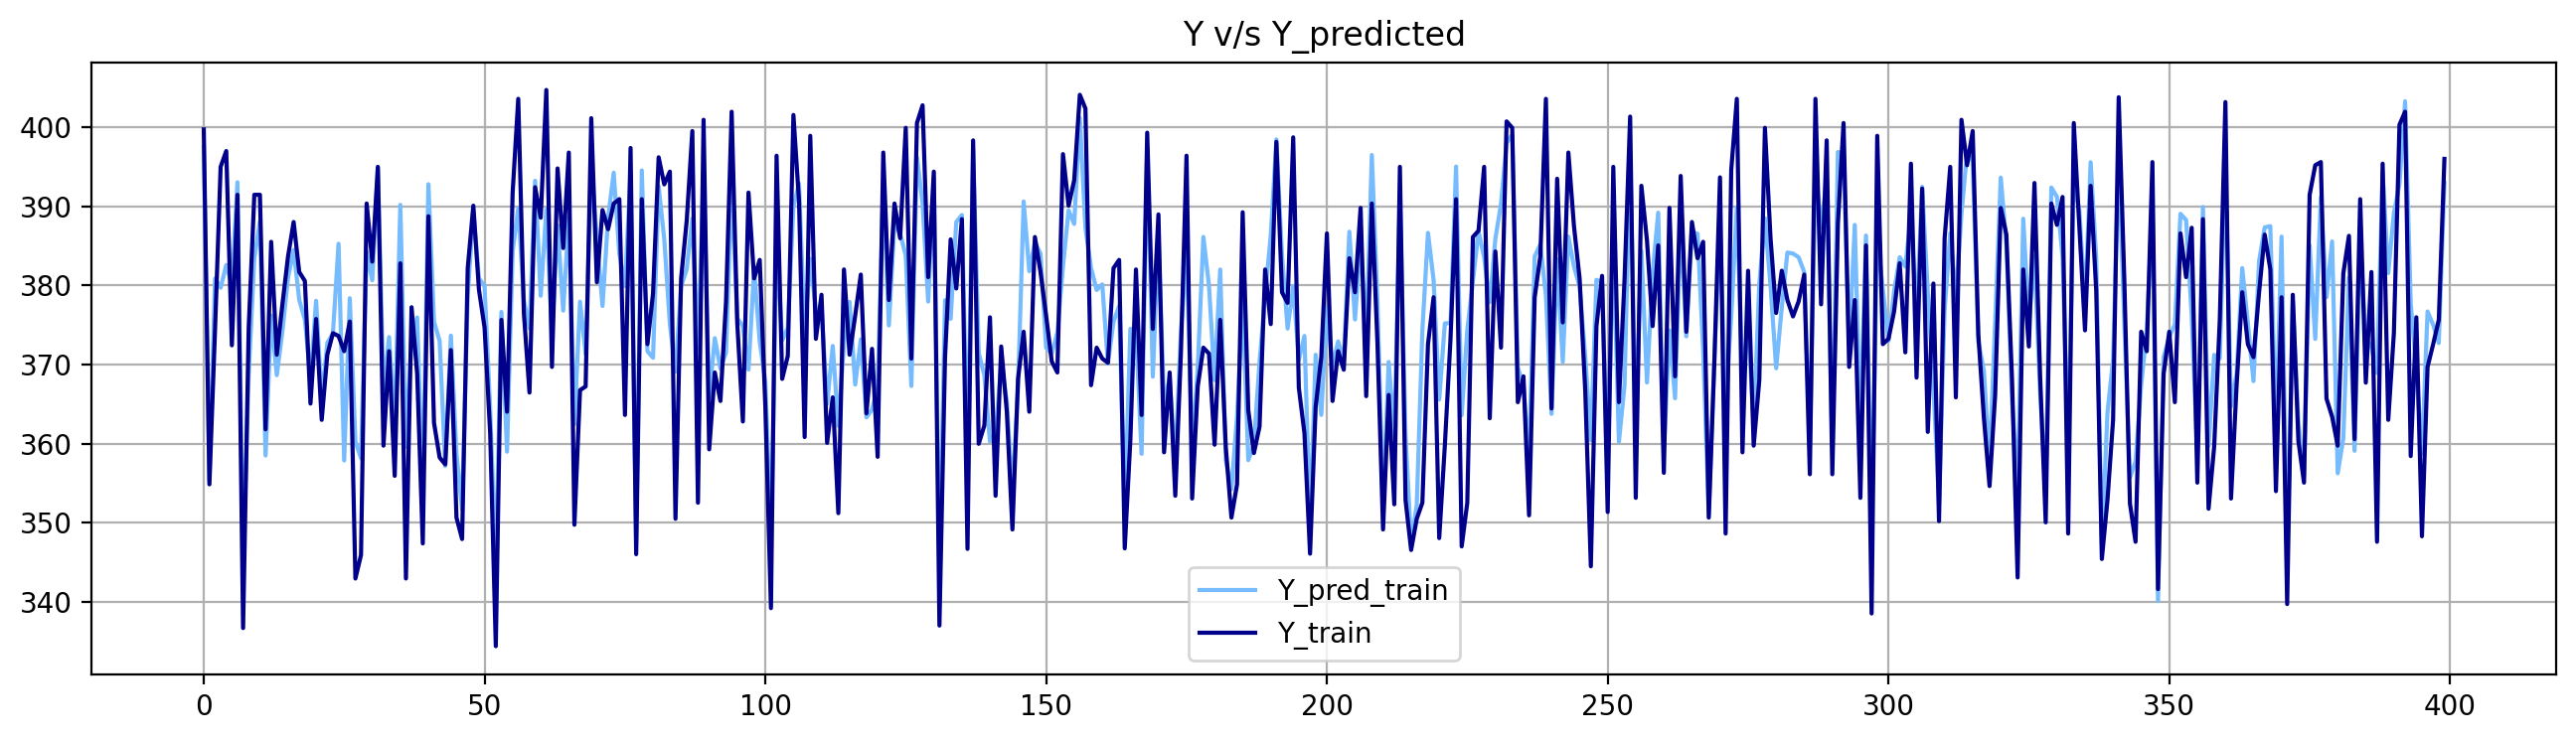

In [24]:
Y_pred = model.predict(X_test)
plt.figure(figsize=(16, 4))
plt.plot(Y_pred_train[:400,], label='Y_pred_train', color= 'xkcd:sky blue',)
plt.plot(Y_train.values[:400,], label='Y_train', color= 'darkblue')
plt.title("Y v/s Y_predicted")
plt.grid()
plt.legend()
plt.show()

### Y_test vs. Y_pred

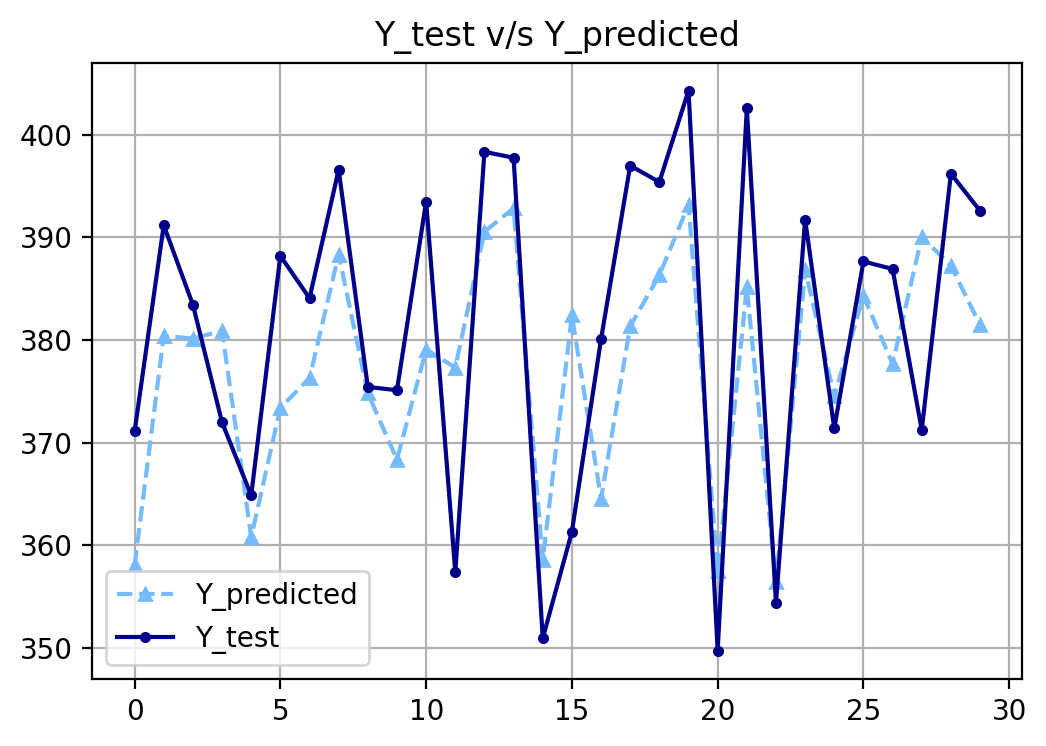

In [19]:
Y_pred_test = model.predict(X_test)
plt.figure(figsize=(6, 4))
plt.plot(Y_pred_test[:30,], label='Y_predicted', marker= '^', 
         markersize=4, color= 'xkcd:sky blue', 
         linestyle='--')
plt.plot(Y_test.values[:30,], label='Y_test', marker= '.', color= 'darkblue')
plt.title("Y_test v/s Y_predicted")
plt.grid()
plt.legend()
plt.show()

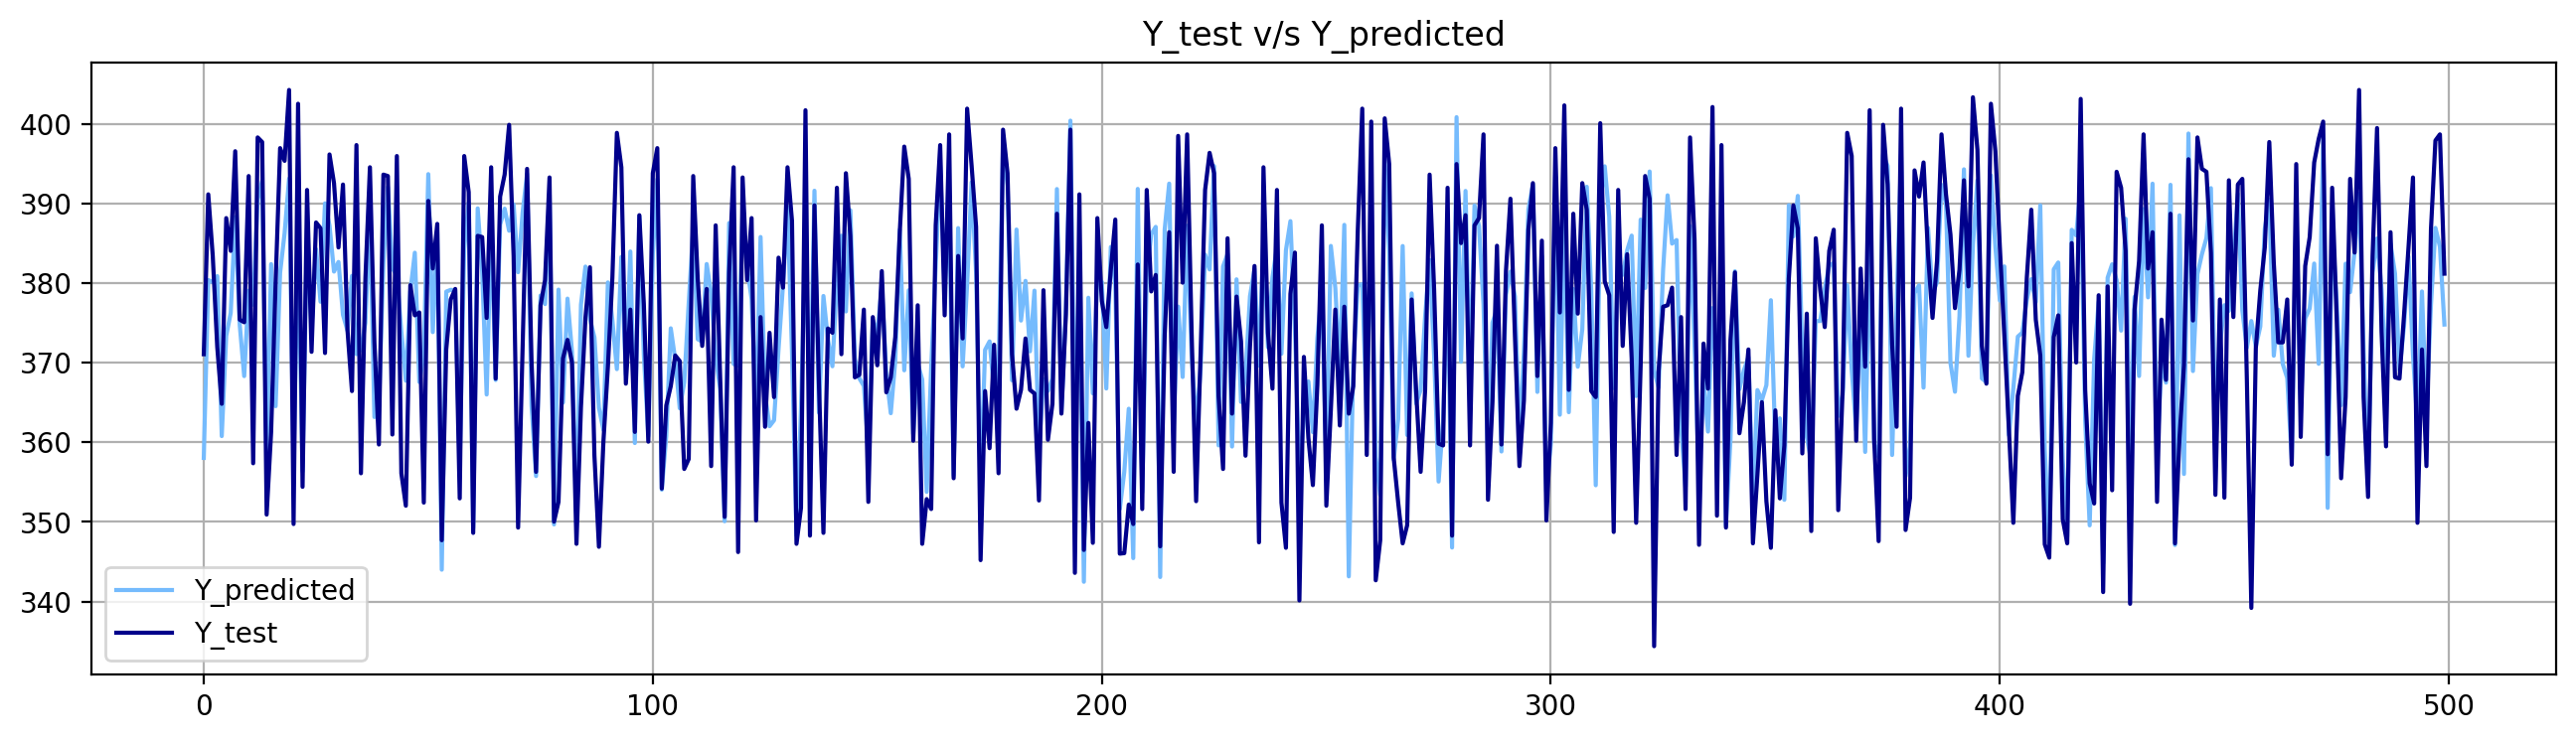

In [20]:
Y_pred = model.predict(X_test)
plt.figure(figsize=(16, 4))
plt.plot(Y_pred[:500,], label='Y_predicted', color='xkcd:sky blue')
plt.plot(Y_test.values[:500,], label='Y_test', color='darkblue')
plt.title("Y_test v/s Y_predicted")
plt.grid()
plt.legend()
plt.show()

### Feature Importance

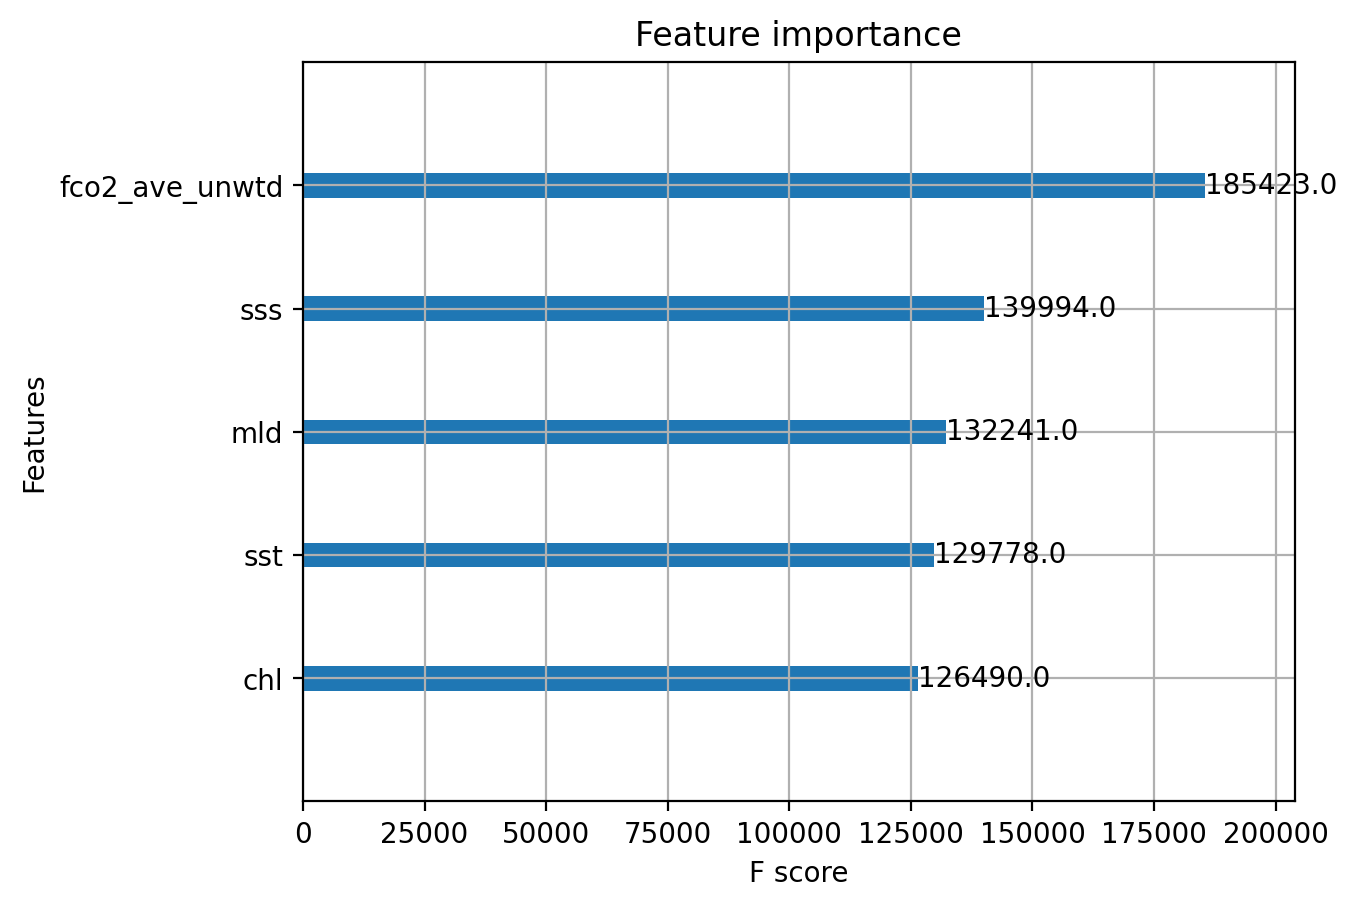

In [21]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [7, 5]
plt.show()

### Second Kind of Training
### k-fold Cross-Validation with XGBoost Models

Additionally, I evaluated the XGBoost model with k-Fold cross-validation. I chose k as five, which means the validation part has five rounds, and then finally got the final RMSE after averaging all five RMSE results. The principle and Procedures of my 5-Fold cross-validation I draw in the following figure.

![RF](images/5k_fold_cv.jpg)

In [22]:
%%time
# Optimized data for XGBoost
data_dmatrix = xgb.DMatrix(data=X,label=Y)
# Cross-Validation of XGBoost models
cv_results = xgb.cv(dtrain=data_dmatrix,
                    params=param_best,
                    nfold=5,
                    num_boost_round=50,
                    early_stopping_rounds=10,
                    metrics="rmse",
                    as_pandas=True,
                    seed=123)

/Users/rebecca/opt/anaconda3/envs/keras/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:03:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:03:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:03:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bv

In [26]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,233.397693,0.007125,233.396698,0.050635
1,145.129373,0.008977,145.130878,0.051885
2,90.591373,0.005245,90.597449,0.051734
3,57.051497,0.011725,57.069035,0.052984
4,36.630197,0.010862,36.692102,0.055861


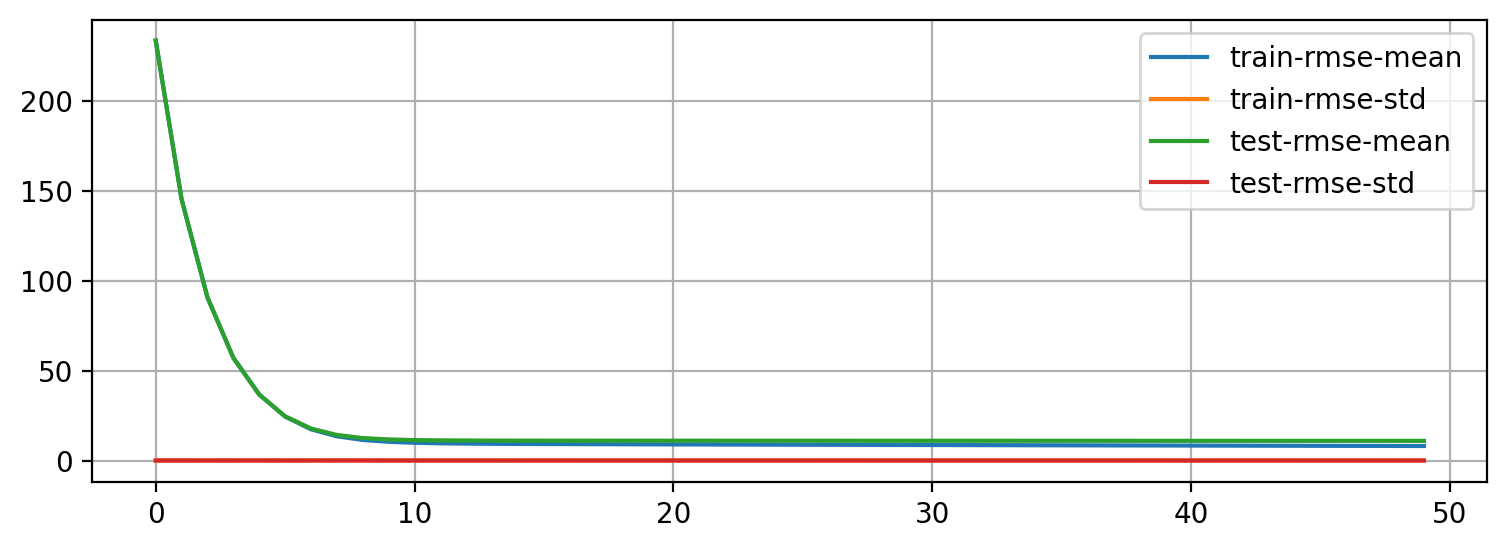

In [30]:
cv_results.plot(figsize=(9, 3))
plt.grid()

### Visualizing individual XGBoost trees

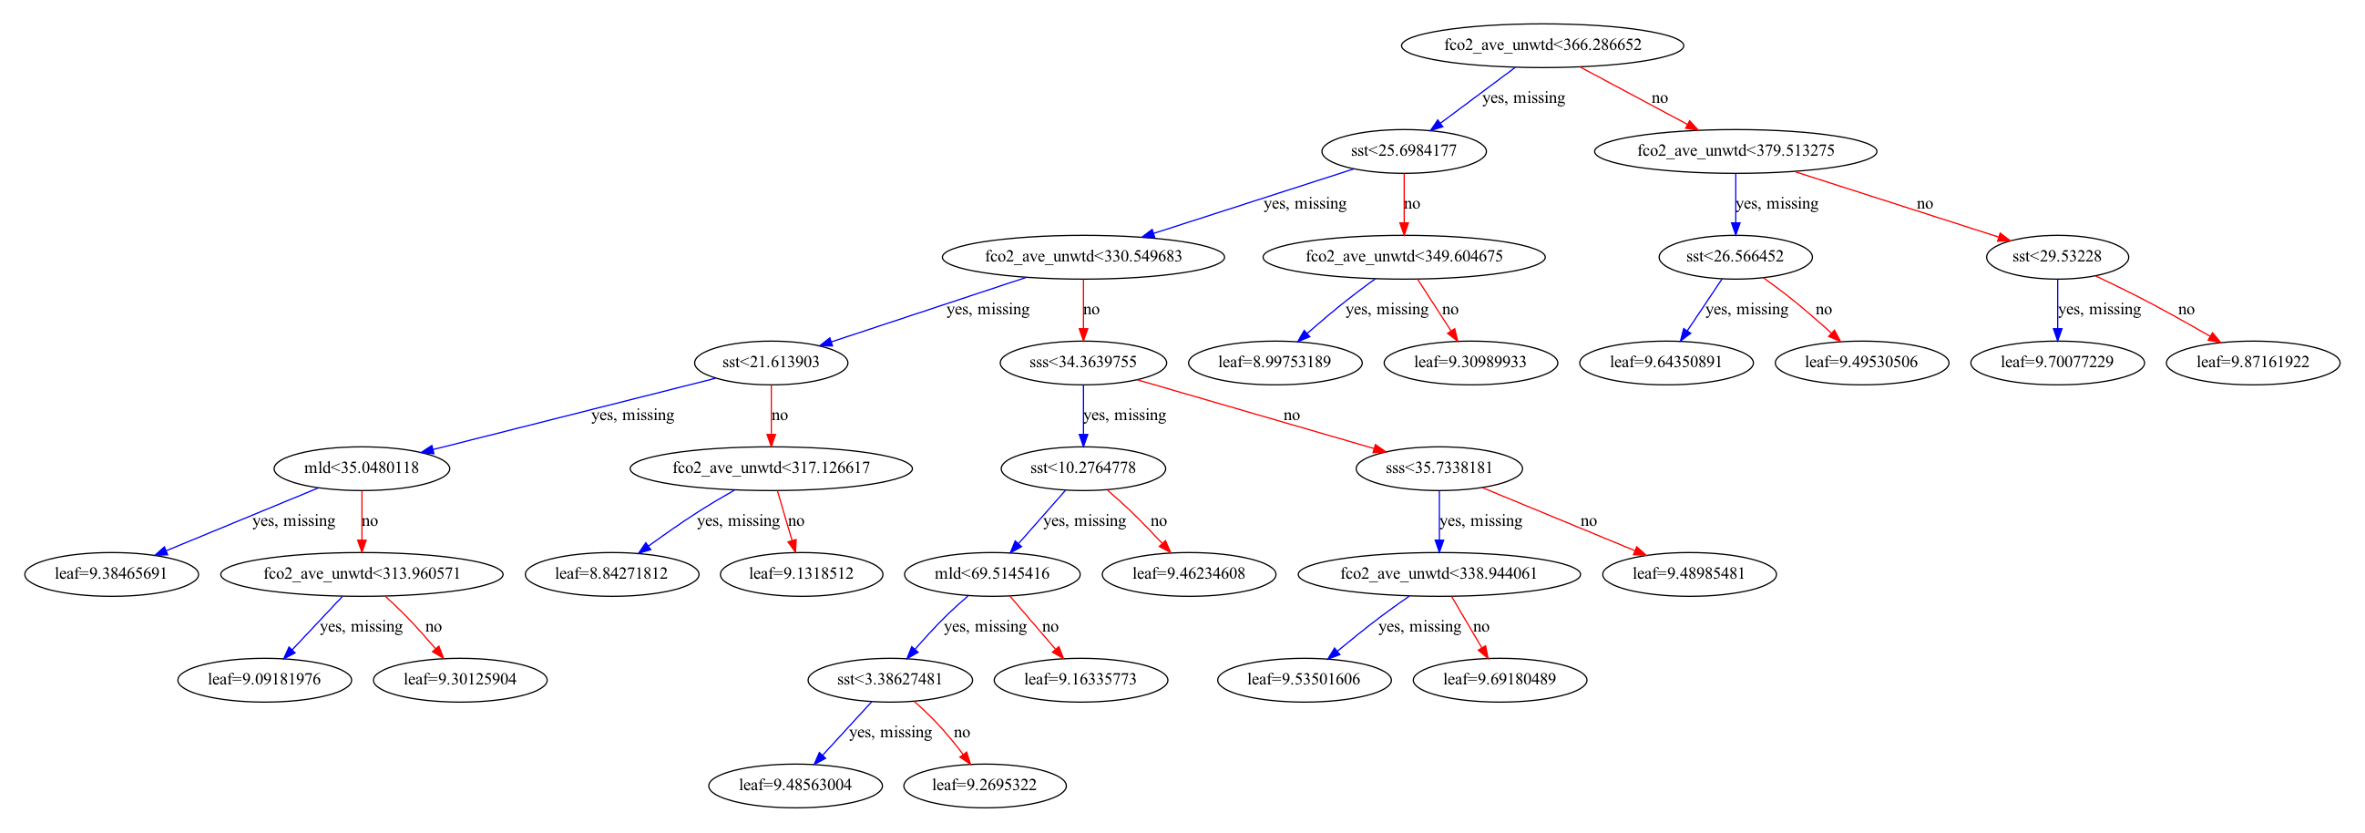

In [25]:
# Plot the first tree
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(model, num_trees=0, ax=ax);

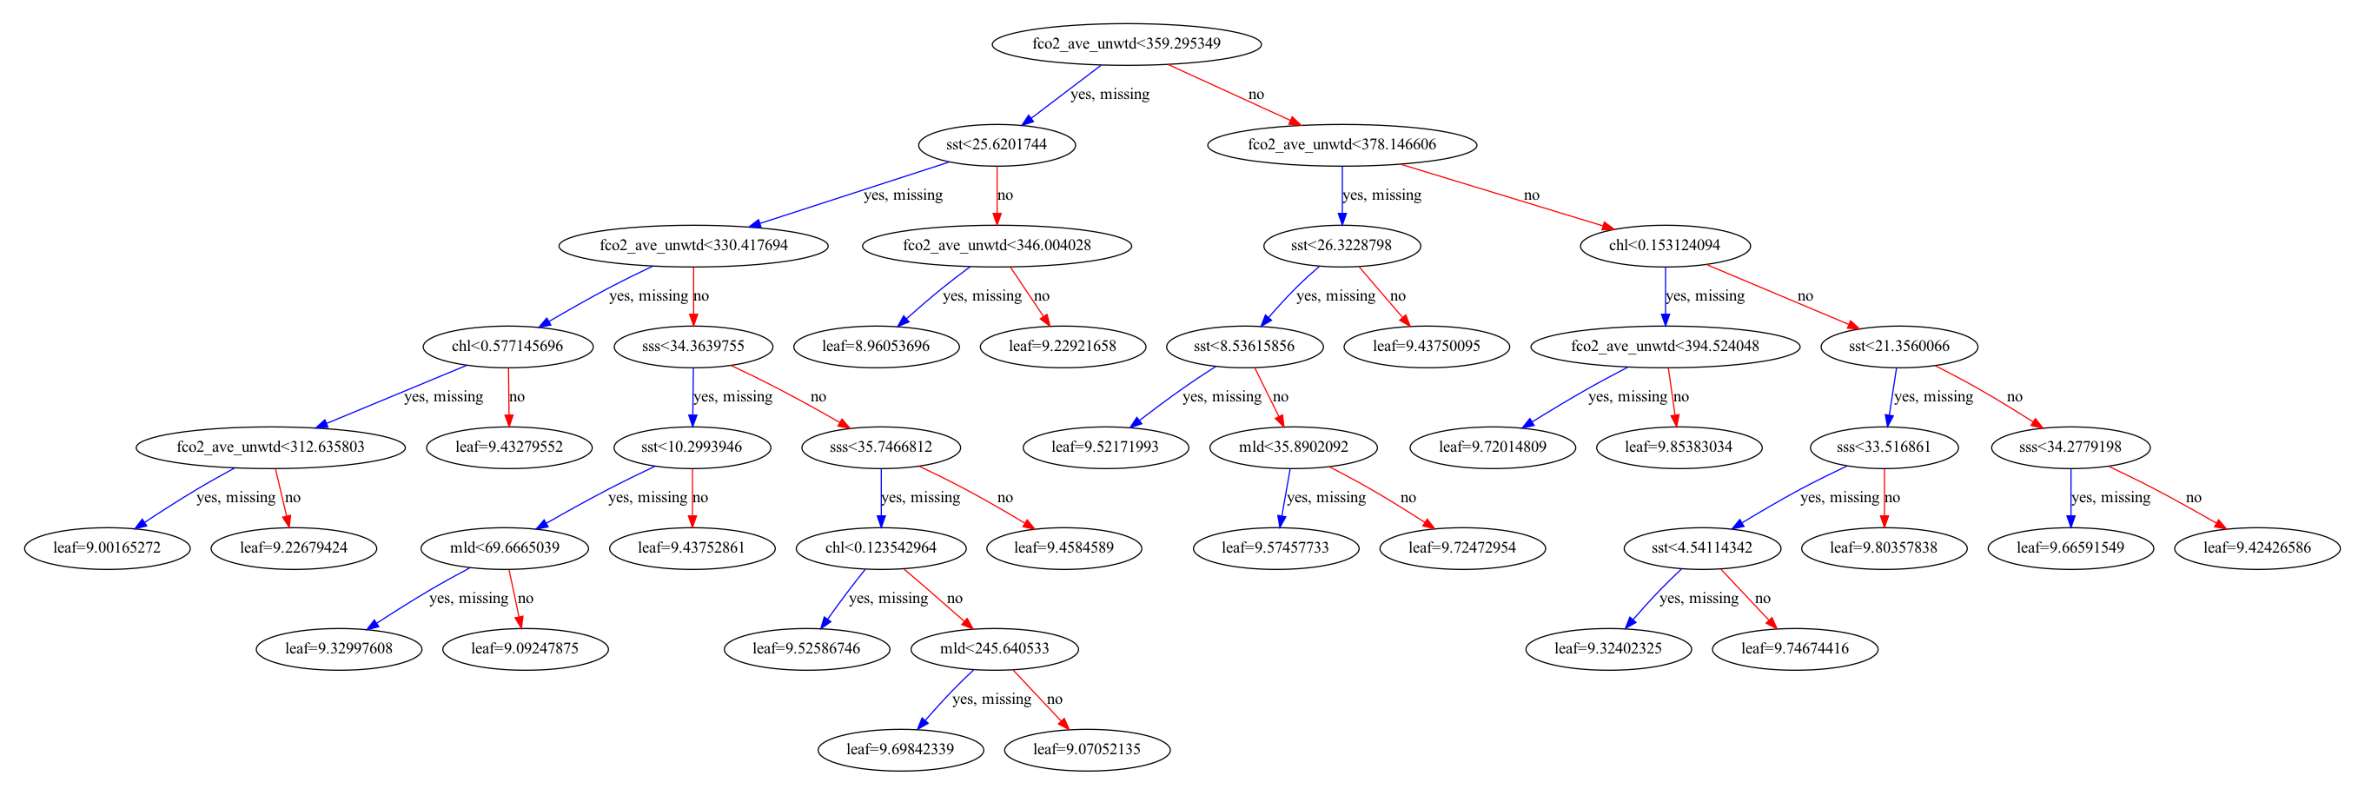

In [31]:
# Plot the second tree
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(model, num_trees=1, ax=ax);

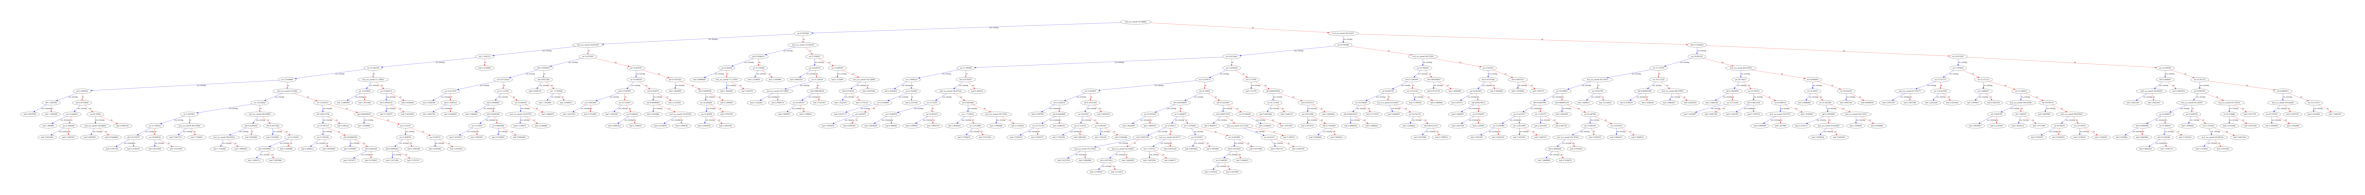

In [29]:
# Plot the thrid tree
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(model, num_trees=499, ax=ax);

### Loss Function Analysis 

I have trained multiple times on my XGBoost models with different parameters in order to decrease the loss which is RMSE. The following four figures are the loss function figure of XGboost model.

![RF](images/XGB_Lossfunction.jpg)

### Appendix. Details for the Training XGBoost Model Parameters

In [ ]:
# # XGBoost parameters
# param_best = {'objective': 'reg:squarederror', 
#               #'reg:squarederror', For Bias prediction 
#               'n_estimators': 18, 
#               # number of runs XGBoost will try to learn
#               'max_depth': 13, 
#               # Maximum depth of a tree, how many levels are in each tree
#               'num_parallel_tree':15,
#               # Number of parallel trees constructed during each iteration
#               'gamma': 0,
#               # Minimum loss reduction required to make a further partition on a leaf node of the tree.
#               'colsample_bytree': 0.95,
#               # Subsample ratio of columns when constructing each tree
              
#               # PREVENT OVERFITTING:
#               'learning_rate': 0.38,
#               # Step size shrinkage used in update to prevents overfitting
#               'min_child_weight': 1, 
#               # Minimum sum of instance weight (hessian) needed in a child. 
#               'subsample': 0.85,
#               # Subsample ratio of the training instances.
              
#               # REGULARIZATION:
#               'alpha': 0.09,
#               # L1 regularization term on weights
#               'labmda': 1,
#               # L2 regularization term on weights
#             }

# # XGBoost Regressor
# model = xgb.XGBRegressor(**param_best)
# # XGBoost training model
# model.fit(X_train,Y_train)